# W6 Lab Exercise
This is the lab exercise for MIS590: Information Retrieval. </br>
In this lab, you will gain the following experience:</br>
- Understand how to fine-tune a pre-trained BERT model for a specific task using a sample dataset.
- Apply the fine-tuned BERT model to rank documents based on their relevance to a given query.
- Evaluate model performance of the fine-tuned model by comparing its output with expected relevance results.
</br>

**Note:** When you see a pencil icon ✏️ in this notebook, it's time for you to code or answer the question!

# 1. Preliminaries

## 1.1 Lab Activity Description

## 1.2 Install and Import Libraries

In [ ]:
# Install necessary libraries
# !pip install pytrec-eval-terrier
# !pip install bertviz
# !pip install datasets

In [1]:
import os
import random

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from datasets import Dataset
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from bertviz import head_view

In [2]:
# Lock the random seed for reproducibility
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed(42)

Random seed set as 42


Make sure you are using GPU!

In [3]:
# Check if GPU is loaded
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and selected as the device.")
else:
    device = torch.device("cpu")
    print("GPU not found, using CPU instead.")

GPU is available and selected as the device.


## 1.3 Input: Query & Document Collections (Corpus)

In [4]:
query = "sleep deprivation"
corpus = [
   "Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.",
    "I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.",
    "Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.",
    "My research data got corrupted, and now I have to start over. The lab mouse escaped, and we spent hours trying to find it. The grant proposal deadline is tomorrow, and the online submission portal is down. At least my pet cactus hasn't died yet.",
    "The group meeting turned into a three-hour debate over font choices for the presentation. I'm pretty sure my colleague is stealing my lunch from the fridge. The photocopier is out to get me; it never works when I'm in a hurry. Is there a PhD in napping? Because I'd ace that.",
    "I haven't seen the sun in days due to endless coding sessions. The simulation keeps crashing, and Stack Overflow doesn't have the answers. My roommate thinks I'm a ghost haunting the apartment. Instant noodles have become my primary food group.",
    "Attending conferences sounded fun until I realized they involve a lot of awkward networking. I accidentally spilled coffee on a famous professor's shoes. My poster fell down twice during the session. Next time, I'll just send a cardboard cutout of myself.",
    "The university gym membership was supposed to keep me healthy, but I've only used it once. I tried to attend a yoga class after staying up late for a deadline, but I fell asleep during the meditation. Maybe instead of the gym, my bed is more essential for keeping me healthy.",
    "My teaching assistantship involves grading endless stacks of exams. Students keep emailing me for extensions with creative excuses. One claimed their dog sleeps on the laptop so they cannot use it for the exam. I was deprived of excuses for not completing my dissertation draft, and I might have got some good ones.",
    "Group projects are the worst when you're the only one doing the work. My team members are as elusive as Bigfoot. The project is due next week, and I haven't heard from them. Perhaps I should just write a paper on the sociological implications of group work avoidance."
]

# Binary labels for the documents' relevancy to the query
# Relevant ones: 1, 2, 5, 6, 8
example_labels = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

# 2. IR with Pretrained BERT

## 2.1 Load Pre-trained BERT Model

In [5]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model_last_lab = BertModel.from_pretrained(model_name)

model_last_lab

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
# Delete the last model and empty the cache
del model_last_lab
torch.cuda.empty_cache()

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)

# Move model to GPU
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### ✏️ Observe the results above and discuss the following:
- In our last lab exercise, we load the BERT model using the following line of code: <br />
`model = BertModel.from_pretrained(model_name)` <br />
However, this time we load BERT using `BertForSequenceClassification`. Can you tell the differences between them? You should be able to see what components are in a BertForSequenceClassification model above.

The BERT model use `BertForSequenceClassification` is different at the final layer. It has an additional layer for classification. The `BertModel` is used for extracting embeddings from the BERT model with output the 768 dimension embeddings. The `BertForSequenceClassification` is used for classification tasks, in this case it maps the 768 dimension embeddings to 2 classes.

In [7]:
# Function to generate BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward
    with torch.no_grad():
        outputs = model(**inputs)

    # Access the last hidden state and the embedding for the [CLS] token
    return outputs.hidden_states[-1][:, 0, :]

In [8]:
inputs = tokenizer(query, return_tensors='pt', padding=True, truncation=True, max_length=512)

# Move inputs to GPU
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward
with torch.no_grad():
    outputs = model(**inputs)
    
# Access the last hidden state and the embedding for the [CLS] token
print(len(outputs.hidden_states), outputs.hidden_states[-1].shape, outputs.hidden_states[-1][:, 0, :].shape)

13 torch.Size([1, 4, 768]) torch.Size([1, 768])


### ✏️ Observe the results above and discuss the following:
- We access the last hidden state and the embedding for the [CLS] token from `outputs.hidden_states[-1][:, 0, :]`. What is in `outputs.hidden_states`?

The `outputs.hidden_states` is a tuple of length 13. Because typically BERT has 12 layers, the first element is the input embeddings, and the rest are the hidden states of each layer. The last element is the output embeddings. When we access `outputs.hidden_states[-1]` we get the output embeddings of the last layer. In this case is [1, 4, 768] tensor. We input 2 word as the input, and there will be add 2 additional token for the input, [CLS] and [SEP]. So finally we get [1, 4, 768] tensor represents the embeddings of the word in the input.
We access the [CLS] token by `outputs.hidden_states[-1][:, 0, :]` which is the first token in the input. The [CLS] token is used for classification tasks in 768 dimension embeddings.

## 2.2 Compute BERT Embeddings

In [9]:
# Compute BERT embeddings for the query
query_embedding = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings = [get_bert_embedding(doc) for doc in corpus]

### Measuring similarity: cosine similarity

In [10]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    vec1 = vec1.numpy()
    vec2 = vec2.numpy()
    dot_product = np.dot(vec1, vec2.T)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

### Rank the documents using cosine similarity

In [11]:
# Rank documents based on similarity to the query
rankings_BERT = []

for idx, doc_embedding in enumerate(corpus_embeddings):
    # Move the embeddings back to cpu so we can compute their cosine similarity
    score = cosine_similarity(query_embedding[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_BERT_srt = sorted(rankings_BERT, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_BERT_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 2 with score 0.8103367686271667
Rank 2: Document 6 with score 0.7880860567092896
Rank 3: Document 5 with score 0.7864928841590881
Rank 4: Document 3 with score 0.7857747673988342
Rank 5: Document 1 with score 0.7844797372817993
Rank 6: Document 10 with score 0.7754190564155579
Rank 7: Document 7 with score 0.7519576549530029
Rank 8: Document 8 with score 0.7409099340438843
Rank 9: Document 4 with score 0.7397842407226562
Rank 10: Document 9 with score 0.7047696709632874


## 2.3 Measure Performance

### Average Precision

In [12]:
# Compute Average Precision (AP) using pytrec_eval package

# Define relevance judgments. These are the documents that are actually relevant to the query
qrel = {
    'q1': {
        'doc1': 1,
        'doc2': 1,
        'doc5': 1,
        'doc6': 1,
        'doc8': 1
    }
}

# Define retrieval results with scores, ensuring scores are native Python floats, not numpy floats
q1 = {"doc"+str(i+1): float(rankings_BERT[i][1]) for i in range(0,10)}

# Define retrieval results with scores
run = {
    'q1': q1
}

evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'map'})
results = evaluator.evaluate(run)
print(f"Average Precision (pytrec_eval): {results['q1']['map']:.4f}")

Average Precision (pytrec_eval): 0.8850


In [13]:
# Use sklearn to compute Average Precision
from sklearn.metrics import average_precision_score

# Define relevance judgments
y_true = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

# Define retrieval results with scores
y_scores = [rankings_BERT[i][1] for i in range(0,10)]

# Compute Average Precision
ap = average_precision_score(y_true, y_scores)
print(f"Average Precision (sklearn): {ap:.4f}")

Average Precision (sklearn): 0.8850


### ✏️ Observe the results above and discuss the following:
- What is the difference between this AP score and that computed by sklearn.metric.average_precision_score?

In this case, they are the same but actually, their formula is different. The `pytrec_eval` is used for evaluating IR system.

# 3. IR with Fine-Tuned BERT



## 3.1 Load the corpus for fine-tuning

### We will be using two different datasets during the fine-tuning process

*   **Training dataset:** For tuning the parameters of BERT.
*   **Evaluation dataset:** For choosing the best fine-tuned model.

**✏️ Upload Corpus.tsv and Eval.tsv**


In [14]:
# Load training corpus and label
corpus_FT = []
labels = []

with open("./Corpus/Corpus.tsv", "r", encoding='utf-8') as f:
    for line in f.readlines():
      parts = line.strip().split("\t")

      if len(parts) == 2:
          corpus_FT.append(parts[0])
          labels.append(int(parts[1]))

In [15]:
# Load eval dataset
eval_corpus = []
eval_labels = []

with open("./Corpus/Eval.tsv", "r", encoding='utf-8') as f:
    for line in f.readlines():
      parts = line.strip().split("\t")

      if len(parts) == 2:
          eval_corpus.append(parts[0])
          eval_labels.append(int(parts[1]))

In [16]:
# Check the number of instances in the training and evaluation sets
print(f"Number of instances in the training set: {len(corpus_FT)}")
print(f"Number of instances in the evaluation set: {len(eval_corpus)}")

Number of instances in the training set: 127
Number of instances in the evaluation set: 20


### ✏️ Observe the results above and discuss the following:
- How many instances are there in the training set?
- How many are there in the evaluation set?
- Why is one of the dataset significantly larger than another?

There are 127 instances in the training set and 10 instances in the evaluation set. The training set is significantly larger than the evaluation set because the training set is used to fine-tune the model, while the evaluation set is used to evaluate the model's performance. Most case the train set will much larger in case of the model need to learn the pattern in the data. The evaluation set is used for testing generalization of the model to prevent overfitting and should not be used for training.

In [17]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Prepare dataset
data = {'text': corpus_FT, 'label': labels}
dataset = Dataset.from_dict(data)
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Prepare evaluation dataset
eval_data = {'text': eval_corpus, 'label': eval_labels}
eval_dataset = Dataset.from_dict(eval_data)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

## 3.2 Fine-Tune BERT

In [18]:
# Fine-Tune BERT

eval_step = 10

# Set up the arguements for fine-tuning
training_args = TrainingArguments(
    output_dir='./results', # Output directory
    num_train_epochs=3, # Number of training epochs
    per_device_train_batch_size=4, # Batch size for training
    per_device_eval_batch_size=8, # Batch size for evaluation
    warmup_steps=10, # Number of warmup steps
    weight_decay=0.01, # We will assign the gradient smaller and smaller weights as the training goes
    logging_dir='./logs', # Log directory
    logging_steps=eval_step, # Log every eval_steps
    eval_strategy="steps", # Evaluate every eval_steps
    eval_steps=eval_step,  # Evaluate every 10 steps
    save_strategy="steps", # Save every eval_steps
    save_steps=eval_step, # Save every 10 steps
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="loss" # Definition of the best model: lowest eval loss
)

# Create a new model for fine-tuning
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)

# Initialize the trainer
trainer = Trainer(
    model=model, # Model to be fine-tuned
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_eval_dataset
)

# Start the fine-tuning process
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrainOutput(global_step=96, training_loss=0.21478433577188602, metrics={'train_runtime': 46.0102, 'train_samples_per_second': 8.281, 'train_steps_per_second': 2.086, 'total_flos': 100245312092160.0, 'train_loss': 0.21478433577188602, 'epoch': 3.0})

### ✏️ Observe the results above and discuss the following:
- What do the outputs indicate?
- Why are there 96 training steps in total?
- How do the different arguments affect the fine-tuning process?
- Explore the content of the `./results` directory. There are 10 models named `./results/checkpoint-xx`. Why are they generated? Why do we want to save these intermediate models instead of just using the final one (i.e., `./results/checkpoint-96`)?
- Explore the content of the `./logs` directory. What information has been recorded?

1. The output indicates the training process of the model. The model is trained for 96 steps with 10 steps for evaluation. The model is saved every 10 steps and the best model is saved at the end of the training. There also show a table ofv train loss and eval loss for each evaluation step. There are also some additional information such as the time taken for each step.
2. We have 127 instances in the training set and the batch size is 4. So we have 127/4 = 31.75, which is rounded up to 32. We have 3 epochs, so we have 32*3=96 training steps.
3. The parameters affect the fine-tuning process as follows:
     - `num_train_epochs`: The number of training epochs. If we have more epochs, the model will be trained more. But if too many will result in overfitting. As far as I deal with BERT, 3 epochs is great fit for most cases.
     - `per_device_train_batch_size`: The batch size for training. The larger the batch size, the faster the training process. But if too large, it will not fit in the GPU memory. Balancing the batch size is important.
     - `per_device_eval_batch_size`: The batch size for evaluation. The same as above. Typically the evaluation batch size is larger than the training batch size. Because we do not need to calculate the gradient, so we can use larger batch size.
     - `warmup_steps`: The number of warmup steps. The warmup steps is used to prevent the model from learning too fast at the beginning of the training. It is used to adjust the learning rate.
     - `weight_decay`: Is the value too large, the model will not learn. If too small, the model will overfit.
4. The 10 models are generated because we save the model every 10 steps. We need to restore the best evaluation model at the end of the training. The final model is not always the best model as it might be overfitting. So we save the intermediate models to choose the best model.
5. The `./logs` directory contains the training logs. The logs contain the training loss, evaluation loss, and the time taken for each step. It is used to monitor the training process. This is tensorboard logs.

## 3.3 Implement IR with Fine-Tuned BERT

In [19]:
# Compute BERT embeddings for the query
query_embedding_FT = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings_FT = [get_bert_embedding(doc) for doc in corpus]

In [20]:
# Rank documents based on similarity to the query
rankings_BERT_FT = []
for idx, doc_embedding in enumerate(corpus_embeddings_FT):
    score = cosine_similarity(query_embedding_FT[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT_FT.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_BERT_FT_srt = sorted(rankings_BERT_FT, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_BERT_FT_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 2 with score 0.7564277052879333
Rank 2: Document 1 with score 0.7180638909339905
Rank 3: Document 8 with score 0.6568138599395752
Rank 4: Document 3 with score 0.442219078540802
Rank 5: Document 6 with score 0.377689391374588
Rank 6: Document 9 with score 0.1950620710849762
Rank 7: Document 10 with score -0.09312116354703903
Rank 8: Document 5 with score -0.10792865604162216
Rank 9: Document 7 with score -0.13875706493854523
Rank 10: Document 4 with score -0.24492812156677246


In [21]:
# Define relevance judgments
def compute_map(rankings: list[tuple[int, float]], qrel: dict[str, dict[str, int]]) -> float:
    q1 = {"doc" + str(i + 1): float(rankings[i][1]) for i in range(0, 10)}  # Convert scores to float
    run = {
        'q1': q1
    }

    evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'map'})
    results = evaluator.evaluate(run)
    return results['q1']['map']


print(f"Average Precision (pytrec_eval): {compute_map(rankings_BERT_FT, qrel):.4f}")

Average Precision (pytrec_eval): 0.8850


In [22]:
# Training with long corpus
corpus_long = []
labels_long = []

with open("./Corpus/Corpus_long.tsv", "r", encoding='utf-8') as f:
    for line in f.readlines():
      parts = line.strip().split("\t")

      if len(parts) == 2:
          corpus_long.append(parts[0])
          labels_long.append(int(parts[1]))
                             
# Prepare dataset
data = {'text': corpus_long, 'label': labels_long}
dataset_long = Dataset.from_dict(data)

# Tokenize the dataset
tokenized_dataset_long = dataset_long.map(tokenize_function, batched=True)

# New a model for fine-tuning
model_long = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)

# Initialize the trainer
trainer_long = Trainer(
    model=model_long,
    args=training_args,
    train_dataset=tokenized_dataset_long,
    eval_dataset=tokenized_eval_dataset
)

# Start the fine-tuning process
trainer_long.train()

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrainOutput(global_step=153, training_loss=0.1533196643770983, metrics={'train_runtime': 94.6679, 'train_samples_per_second': 6.37, 'train_steps_per_second': 1.616, 'total_flos': 158655966382080.0, 'train_loss': 0.1533196643770983, 'epoch': 3.0})

In [23]:
# Evaluate the fine-tuned model with same query and corpus
# Compute BERT embeddings for the query
query_embedding_FT_long = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings_FT_long = [get_bert_embedding(doc) for doc in corpus]

# Rank documents based on similarity to the query
rankings_BERT_FT_long = []
for idx, doc_embedding in enumerate(corpus_embeddings_FT_long):
    score = cosine_similarity(query_embedding_FT_long[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT_FT_long.append((idx + 1, score))
    
rankings_BERT_FT_long_srt = sorted(rankings_BERT_FT_long, key=lambda x: x[1], reverse=True)

print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_BERT_FT_long_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")
    
# Relevance judgments
print(f"Average Precision (pytrec_eval): {compute_map(rankings_BERT_FT_long, qrel):.4f}")

Document Rankings based on BERT embeddings:
Rank 1: Document 1 with score 0.7542176246643066
Rank 2: Document 2 with score 0.744404673576355
Rank 3: Document 8 with score 0.7116522789001465
Rank 4: Document 6 with score 0.48090359568595886
Rank 5: Document 3 with score 0.41151654720306396
Rank 6: Document 5 with score 0.2582605481147766
Rank 7: Document 9 with score -0.023637549951672554
Rank 8: Document 4 with score -0.21295954287052155
Rank 9: Document 7 with score -0.24510200321674347
Rank 10: Document 10 with score -0.29434147477149963
Average Precision (pytrec_eval): 0.9667


### ✏️ Observe the results above and discuss the following:
- Does the fine-tuned BERT model outperform the pre-trained BERT model in the IR task?
- If it does, why do you think the results turned out this way?
- In this lab exercise, we fine-tune the BERT model with 127 documents, which is relatively small training set. Try fine-tuning the model with `Corpus_long.tsv` or ask ChatGPT to generate some more corpus to fine-tune with. Do more training data enhance IR performance?

1. Yes, it performs similar to the pre-trained BERT model in my case. The Average Precision (AP) score of the fine-tuned model is higher than the pre-trained model.
2. The pre-trained model is trained on a general task, so it might not perform well on a specific task. But after fine-tuning, the model is trained on a specific task, so it performs better on the IR task.
3. In my case it has a great improvement. In general, more training data will enhance the performance of the model. The model will learn more patterns in the data and generalize better. But it also depends on the quality of the data. If the data is noisy, the model will sometime perform worse.

# 4. Analysis

## 4.1 Visualizing The Distribution of Embeddings


Let's observe how fine-tuning change the documents and query are represented in the vector space.

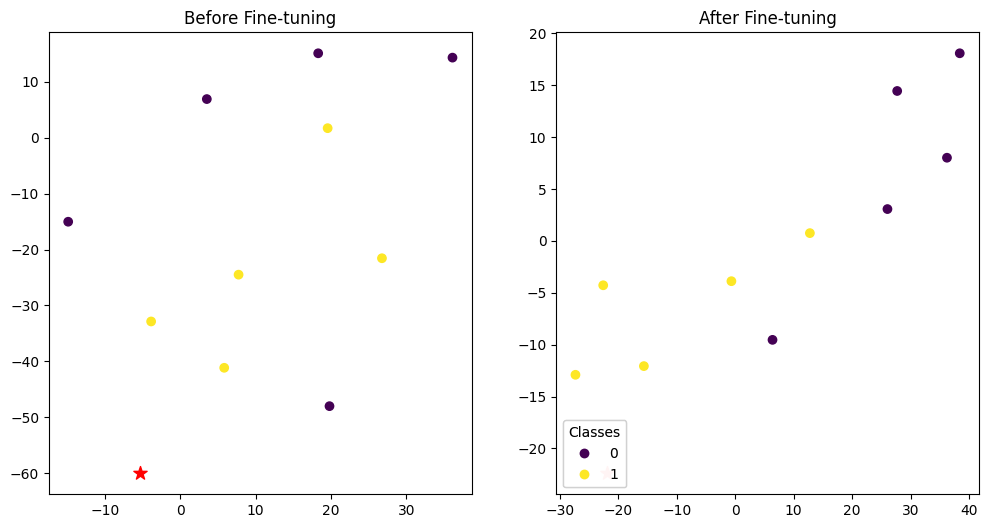

In [24]:
# Combine query and document embeddings (before fine-tuning)
all_embeddings_before = [query_embedding] + corpus_embeddings
# Combine query and document embeddings (after fine-tuning)
all_embeddings_after = [query_embedding_FT_long] + corpus_embeddings_FT_long

# Concatenate all embeddings and move them to CPU for further processing
all_embeddings_before_tensor = torch.cat(all_embeddings_before, dim=0).cpu()  # Concatenate and move to CPU
all_embeddings_after_tensor = torch.cat(all_embeddings_after, dim=0).cpu()  # Concatenate and move to CPU

# Create labels where 0 corresponds to the query, and the rest to documents
all_labels = [0] + example_labels  # Add a label for the query (e.g., 0)

# Apply t-SNE to reduce the dimensionality of embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_before_2d = tsne.fit_transform(all_embeddings_before_tensor.numpy())  # Embeddings before fine-tuning in 2D
embeddings_after_2d = tsne.fit_transform(all_embeddings_after_tensor.numpy())  # Embeddings after fine-tuning in 2D

# Extract query and document embeddings (before and after fine-tuning) for plotting
query_embedding_before_2d = embeddings_before_2d[0]  # Query embedding before fine-tuning
corpus_embeddings_before_2d = embeddings_before_2d[1:]  # Document embeddings before fine-tuning

query_embedding_after_2d = embeddings_after_2d[0]  # Query embedding after fine-tuning
corpus_embeddings_after_2d = embeddings_after_2d[1:]  # Document embeddings after fine-tuning

# Plot the embeddings before and after fine-tuning side by side
plt.figure(figsize=(12, 6))

# Plot for embeddings before fine-tuning
plt.subplot(1, 2, 1)
scatter = plt.scatter(corpus_embeddings_before_2d[:, 0], corpus_embeddings_before_2d[:, 1], c=example_labels, label='Documents')  # Plot documents
plt.scatter(query_embedding_before_2d[0], query_embedding_before_2d[1], c='red', marker='*', s=100, label='Query')  # Highlight the query embedding
plt.title('Before Fine-tuning')  # Add title

# Plot for embeddings after fine-tuning
plt.subplot(1, 2, 2)
scatter = plt.scatter(corpus_embeddings_after_2d[:, 0], corpus_embeddings_after_2d[:, 1], c=example_labels, label='Documents')  # Plot documents
plt.scatter(query_embedding_after_2d[0], query_embedding_after_2d[1], c='red', marker='*', s=100, label='Query')  # Highlight the query embedding
plt.title('After Fine-tuning')  # Add title

# Add a legend to show which colors correspond to which labels
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

### ✏️ Observe the results above and discuss the following:
- According to the visualization, can you infer why fine-tuning leads to better IR results?
- What is t-SNE? What does it do?

1. After fine-tuning, the relevance of the documents to the query is more clearly separated. The query and the relevant documents are closer to each other, while the irrelevant documents are further away. I think it is because the model is trained on the specific task, and it know closer to the relevant documents will have lower loss. That mean it is more suitable for the IR task.
2. `t-SNE` is a dimensionality reduction technique that is used for visualizing high-dimensional data in 2D or 3D. Because of the original data is high-dimensional (768 in this case), it is hard to visualize. With reducing the dimensionality, we can analyze the data more easily. The closer the points in the t-SNE plot, the more similar they are in the original high-dimensional space. So it can be used in analysis the model performance.

## 4.2 Visualizing The Attention

Let's use the following setence as example:

In [25]:
vis_sent = "I pulled another all-nighter trying to finish this project. Coffee has become my best friend."

### Visualizing Attention from Fine-Tuned BERT

In [26]:
# Input text for visualization
input_text = vis_sent

# Tokenize the input text
inputs = tokenizer.encode_plus(input_text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs.get('token_type_ids')
attention_mask = inputs.get('attention_mask')

# Move inputs to the appropriate device (GPU if available)
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None
attention_mask = attention_mask.to(device) if attention_mask is not None else None

# Get model outputs, ensuring to get attention weights
# The key change is here: output_attentions=True
outputs = model_long(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Access attention weights from the outputs

# Get the tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize attention
head_view(attention, tokens)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

### Visualizing Attention from Pretrained BERT

Load the pretrained BERT again (`model` has now been fine-tuned)

In [27]:
model_pre = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)  # Adjust num_labels as needed
model_pre.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
# Input text for visualization
input_text = vis_sent

# Tokenize the input text
inputs = tokenizer.encode_plus(input_text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs.get('token_type_ids')
attention_mask = inputs.get('attention_mask')

# Move inputs to the appropriate device (GPU if available)
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None
attention_mask = attention_mask.to(device) if attention_mask is not None else None

# Get model outputs, ensuring to get attention weights
# The key change is here: output_attentions=True
outputs = model_pre(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Access attention weights from the outputs

# Get the tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize attention
head_view(attention, tokens)

<IPython.core.display.Javascript object>

### ✏️ Observe the results above and discuss the following:
- How can we read this diagram?
- What are the words that contribute the most to the relevance classification task?
- How are the attention scores change after fine-tuning?

1. The head view visualizes attention in one or more heads from a single Transformer layer. Each line shows the attention from one token (left) to another (right). Line weight reflects the attention value (ranges from 0 to 1), while line color identifies the attention head. When multiple heads are selected (indicated by the colored tiles at the top), the corresponding visualizations are overlaid onto one another. 
   - When hovering over a token, the visualization highlights the attention it receives from other tokens. 
   - Double-clicking on colored tiles at the top will filter to the corresponding attention heads. 
   - Single-click on any of the colored tiles to toggle selection of the corresponding attention head. 
   - Click on the Layer drop-down to change the model layer (zero-indexed).
2. The words  "another", "to" have higher attention scores. This observation is from the first layer of the model. So for the "sleep deprivation" task, the relation might be even more abstract. So it is hard to interpret from the first layer. So I try to go further, and I found that the words "night", "project" have higher attention scores when move to the third layer. This shows up somehow the model learn the relationship for "sleep deprivation".
3. After fine-turned model, at the layer at 3rd, "night", "project", become higher than the pre-trained model also it can be found that the pre-trained one have a lot of attention score for the word "all" but we can't find it in the fine-tuned model. It means that the model learns the relationship of the keywords for the task even better. In the other words, the model is more suitable for the task after fine-tuning.

# Assignment 2

## 1. Discussion Questions

Answer the discussion questions above (those with ✏️ icon).

## 2. Diving Deeper into Model Fine-Tuning Analysis

Refer to the following work that investigate BERT's behavior post fine-tuning:

```
    Yichu Zhou and Vivek Srikumar. 2022. A Closer Look at How Fine-tuning Changes BERT. In Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 1046–1061, Dublin, Ireland. Association for Computational Linguistics.
```

In Section 4 Observations and Analysis, the authors show several obsevation on how fine-tuning changes BERT. Try to replicate **at least two** of their analysis in 4.1 to 4.3 and see if their discovery aligns with yours.<br />

### 2.1 Replicate the Analysis of Fine-tuned performances of BERTsmall based on the last layers.


## 3. **Bonus Question:** Cross-Encoder IR with BERT

In our previous and current lab activity, we simply use BERT as an encoder to obtain query and document representations. We then rank the documents based on their cosine similarity to the query. This is called a **bi-encoder** or **dual encoder** structure. There is another structure called a **cross encoder**, where we do not learn the representations of the query and document separately. Instead, we concatenate them together as a single input to BERT, and classify the resulting representation as a relevant or irrelevant sentence pair. An illustration of the two encoders is shown below:<br />
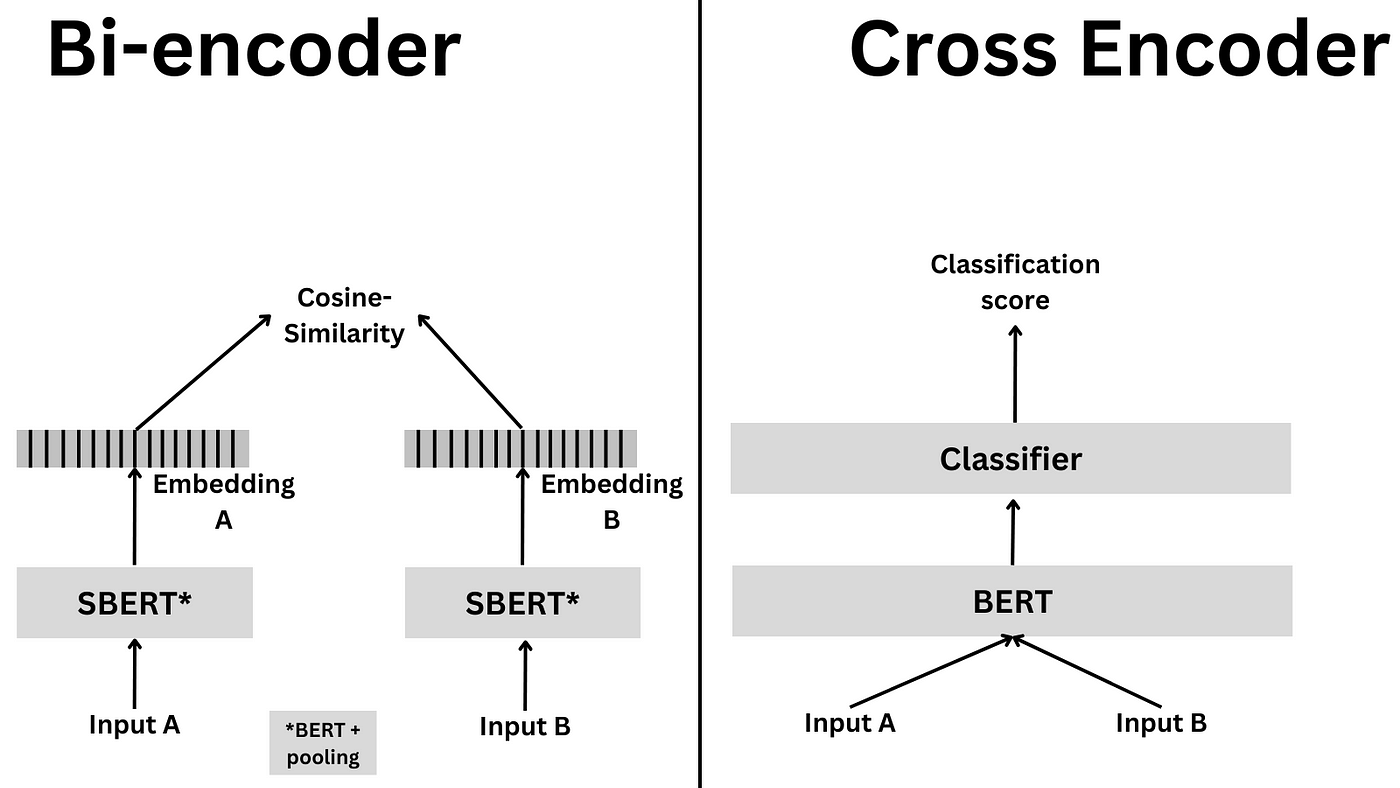

Implement a cross-encoder IR system using BERT. Fine-tune the model and compare its performance to the bi-encoder IR system.

## 💻 Assignment Submission 💻
Write your code and display the results in this Jupyter Notebook. Then, export it as an HTML file and submit both the Jupyter Notebook and the HTML file to Cyber University. (I will show you how to download this notebook and export HTML in class) </br>
**Please ensure that the code is executed and the outputs are visible when exporting the HTML file.**